In [ ]:
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
import torch
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/project/') # customize this line to your working directory

Mounted at /content/drive


In [ ]:
df = pd.read_csv('final_raw_data.csv')

In [ ]:
df_train_timestamp = df[df["Date"]<= "2023-10-31"]['Close']
df_train_timestamp = df_train_timestamp.values.reshape(-1,1)
df_test_timestamp = df[df["Date"]> "2023-10-31"]['Close']
df_test_timestamp = df_test_timestamp.values.reshape(-1, 1)
df_train_timestamp.shape

(669, 1)

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 5
X_train_lightgbm, y_train_lightgbm = create_dataset(df_train_timestamp, time_step)
X_test_lightgbm, y_test_lightgbm = create_dataset(df_test_timestamp, time_step)

print("X_train: ", X_train_lightgbm.shape)
print("y_train: ", y_train_lightgbm.shape)
print("X_test: ", X_test_lightgbm.shape)
print("y_test", y_test_lightgbm.shape)

X_train:  (663, 5)
y_train:  (663,)
X_test:  (85, 5)
y_test (85,)


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV

# Assuming X_train_lightgbm, y_train_lightgbm, X_test_lightgbm, y_test_lightgbm are your training and testing data

# Set LightGBM parameters
params = {
    'objective': 'regression',  # Use regression objective
    'num_leaves': 31,  # Maximum number of leaves in one tree
    'learning_rate': 0.05,  # Learning rate
    'verbose': 0  # Suppress output
}

# Define a parameter grid for grid search
param_grid = {
    'num_leaves': [15, 31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.7, 0.8, 0.9],
    'bagging_freq': [3, 5, 7]
}

# Perform grid search with cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Define 5-fold cross-validation
grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(**params), param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train_lightgbm, y_train_lightgbm)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Fit the LightGBM model with the best parameters
bst = lgb.train({**params, **best_params}, lgb.Dataset(X_train_lightgbm, label=y_train_lightgbm))

# Make predictions on the test set
y_pred = bst.predict(X_test_lightgbm)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test_lightgbm, y_pred) ** 0.5
print(f"RMSE: {rmse}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Best Parameters: {'bagging_fraction': 0.8, 'bagging_freq': 7, 'feature_fraction': 0.9, 'learning_rate': 0.05, 'num_leaves': 15}
RMSE: 1278.1132802331963


In [ ]:
import math

In [ ]:
print("R saquared - R^2 : " + str(math.sqrt(r2_score(y_test_lightgbm, y_pred))))

R saquared - R^2 : 0.9076441152809961


In [ ]:
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test_lightgbm, y_pred)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test_lightgbm, y_pred))))

Mean Absolute Error - MAE : 996.6471843622402
Root Mean squared Error - RMSE : 1278.1132802331963


In [ ]:
x_input = df[-25:]['Close'].values.reshape(-1,1)
time_step = 5
pred_dates = 10
X_train_lightgbm_next_10, y_train_lightgbm_next_10 = create_dataset(x_input, time_step)
y_pred_lightgbm_next_10 = bst.predict(X_train_lightgbm_next_10)
y_pred_lightgbm_next_10 = y_pred_lightgbm_next_10[time_step:]
y_pred_lightgbm_next_10 = y_pred_lightgbm_next_10[:time_step+pred_dates]

In [ ]:

prediction_output_lightgbm = y_pred_lightgbm_next_10[:time_step]
for i in range(pred_dates):
    y_pred_next_1 = bst.predict(prediction_output_lightgbm[-time_step:].reshape(1,time_step))
    prediction_output_lightgbm = np.append(prediction_output_lightgbm, y_pred_next_1)
prediction_output_lightgbm

array([42188.50702147, 42635.99155321, 42924.40796258, 40880.73324398,
       41057.60266711, 40946.22681779, 40884.45459233, 41391.54332588,
       41318.89547998, 41490.09521378, 41576.68343732, 41584.89828571,
       41670.29857316, 41670.29857316, 41670.29857316])

In [ ]:
# True Value
actual_value_lightgbm = x_input[time_step:pred_dates+time_step*2]
actual_value_lightgbm

array([[46368.5859375 ],
       [42853.16796875],
       [42842.3828125 ],
       [41796.26953125],
       [42511.96875   ],
       [43154.9453125 ],
       [42742.65234375],
       [41262.05859375],
       [41618.40625   ],
       [41665.5859375 ],
       [41545.78515625],
       [39507.3671875 ],
       [39845.55078125],
       [40077.07421875],
       [39933.80859375]])

In [ ]:
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(actual_value_lightgbm, prediction_output_lightgbm)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(actual_value_lightgbm, prediction_output_lightgbm))))

Mean Absolute Error - MAE : 1252.2317885882726
Root Mean squared Error - RMSE : 1676.295580317927


In [ ]:
SSE = np.sum((actual_value_lightgbm - prediction_output_lightgbm)**2)
SST = np.sum((actual_value_lightgbm - np.mean(prediction_output_lightgbm))**2)
1 - SSE/SST

-15.76276217877411

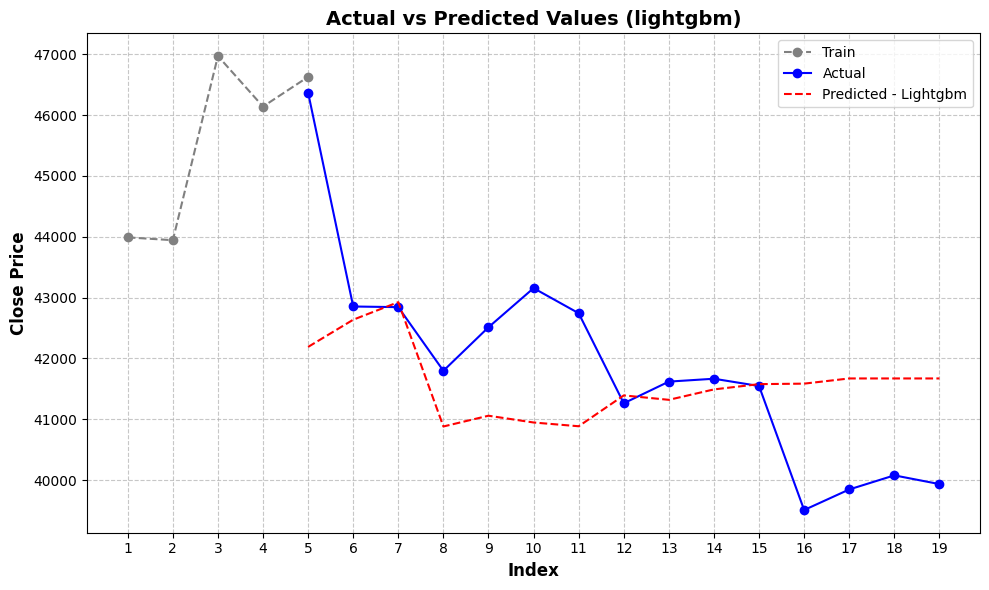

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

index_values = np.arange(time_step, pred_dates + time_step * 2)
train_index_value = np.arange(1, time_step + 1)

# Plot the actual values (y_test) and predicted values (y_pred)
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train_index_value, x_input[:time_step], label="Train", linestyle='--', marker='o', color='gray')

# Plot actual values
plt.plot(index_values, actual_value_lightgbm, label='Actual', color='blue', marker='o')

# Plot predicted values
plt.plot(index_values, prediction_output_lightgbm, label='Predicted - Lightgbm', color='red', linestyle='--')

# Plot original predicted values
#plt.plot(index_values, y_pred_xgboost_next_10, label='Original-Predicted', color='green', linestyle='-.')

# Set integer ticks for x-axis
plt.xticks(np.arange(1, max(index_values)+1, 1))

plt.title('Actual vs Predicted Values (lightgbm)', fontsize=14, fontweight='bold')
plt.xlabel('Index', fontsize=12, fontweight='bold')
plt.ylabel('Close Price', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()